- Libraries

In [1]:
import pandas as pd
import numpy as np
from DateTime import DateTime
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
# from statsmodels.tsa.stattools import adfuller
# from sklearn.metrics import mean_squared_error
# from statsmodels.tools.eval_measures import rmse
# from sklearn import metrics
import warnings

warnings.filterwarnings("ignore")
from src.functions_torch import TransformLag
from src.feature import TimeConfig


In [2]:
timec= TimeConfig()
df= timec.process_chain(path='../Data/apple.csv',columns=['Close/Last'])


In [3]:
df= df.loc['2021':'2024'].copy()

In [4]:
df


,Value
Date,
2021-01-04,129.41
2021-01-05,131.01
2021-01-06,126.60
2021-01-07,130.92
2021-01-08,132.05
...,...
2024-05-22,190.90
2024-05-23,186.88
2024-05-24,189.98


- Plotting the Data

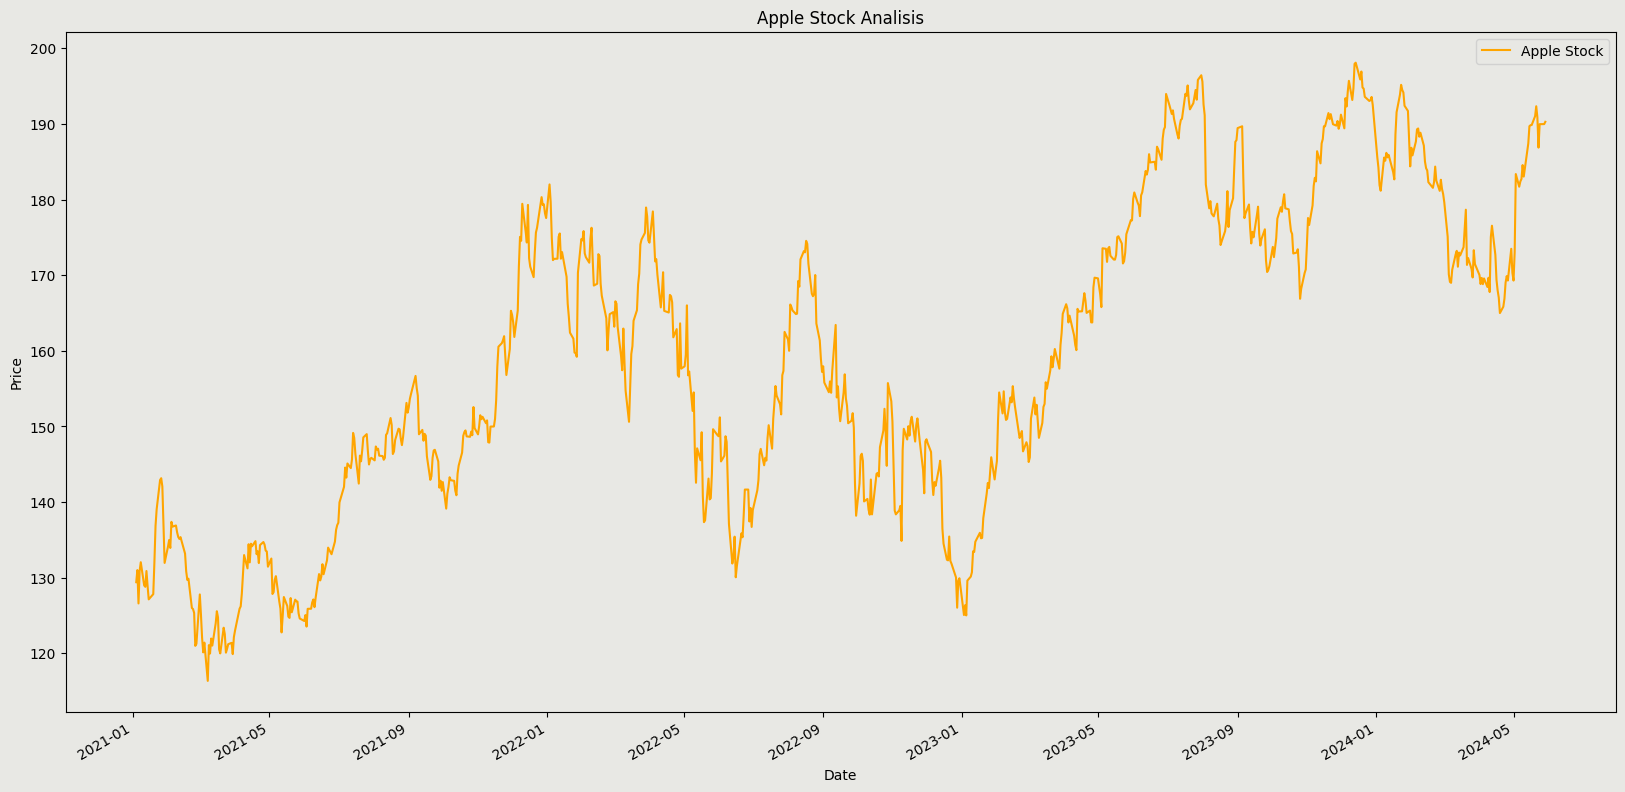

In [5]:
df["Value"].plot(figsize=(20,10),label="Apple Stock",color="orange")
plt.title("Apple Stock Analisis")
plt.xlabel("Date")
plt.ylabel("Price")
plt.gca().set_facecolor("#E8E8E4")
plt.gcf().set_facecolor("#E8E8E4")
plt.legend(facecolor="#E8E8E4")
plt.show()

In [6]:
timef= TransformLag()
data= timef.lag_transform(df,3)

In [8]:
data= data.to_numpy()

- Escalado de valores del array entre -1,1 para alimentar el modelo

In [10]:
scaler= MinMaxScaler(feature_range=(-1,1))
transformed= scaler.fit_transform(data)


array([[-0.64379205, -0.74948012, -0.64159021, -0.68073394],
       [-0.61614679, -0.64379205, -0.74948012, -0.64159021],
       [-0.61614679, -0.64379205, -0.74948012, -0.64159021],
       ...,
       [ 0.80110092,  0.72525994,  0.82360856,  0.85908257],
       [ 0.80134557,  0.80110092,  0.72525994,  0.82360856],
       [ 0.80868502,  0.80134557,  0.80110092,  0.72525994]])

- Haciendo Slicing para dividir el dato de entrenamiento y el target

In [12]:
X= transformed[:,1:]
y= transformed[:,0]

In [15]:

X= dc(np.flip(X,axis=1))
split_index= int(len(X) * 0.80)
X_train= X[:split_index]
X_test= X[split_index:]
y_train= y[:split_index]
y_test= y[split_index:]

In [ ]:
X_train= X_train.reshape((-1,3,1))
X_test= X_test.reshape((-1,3,1))
y_train= y_train.reshape((-1,1))
y_test= y_test.reshape((-1,1))

In [ ]:
X_train= torch.tensor(X_train).float()
X_test= torch.tensor(X_test).float()
y_train= torch.tensor(y_train).float()
y_test= torch.tensor(y_test).float()

In [14]:
class TimeSeries(Dataset):
    def __init__(self,X,y):
        self.X= X
        self.y= y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        return self.X[i],self.y[i]

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    
seed=42
set_seed(seed)
batch_size = 18
train_dataset= TimeSeries(X_train,y_train)
test_dataset= TimeSeries(X_test,y_test)

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [26]:
y_train

tensor([[-6.4379e-01],
        [-6.1615e-01],
        [-6.1615e-01],
        [-6.1615e-01],
        [-6.9125e-01],
        [-6.9566e-01],
        [-6.4453e-01],
        [-6.9297e-01],
        [-7.3627e-01],
        [-7.3627e-01],
        [-7.3627e-01],
        [-7.3627e-01],
        [-7.1939e-01],
        [-6.1664e-01],
        [-4.9823e-01],
        [-4.4440e-01],
        [-4.4440e-01],
        [-4.4440e-01],
        [-3.5021e-01],
        [-3.4434e-01],
        [-3.7125e-01],
        [-4.9284e-01],
        [-6.1835e-01],
        [-6.1835e-01],
        [-6.1835e-01],
        [-5.6502e-01],
        [-5.4422e-01],
        [-5.6991e-01],
        [-4.8550e-01],
        [-5.0092e-01],
        [-5.0092e-01],
        [-5.0092e-01],
        [-4.9725e-01],
        [-5.1927e-01],
        [-5.3443e-01],
        [-5.4080e-01],
        [-5.3492e-01],
        [-5.3492e-01],
        [-5.3492e-01],
        [-5.3492e-01],
        [-5.8826e-01],
        [-6.4575e-01],
        [-6.7339e-01],
        [-6

In [16]:
for _,batch in enumerate(train_loader):
    x_batch,y_batch= batch[0].to(device),batch[1].to(device)
    print(x_batch.shape,y_batch.shape)
    break

class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_stacked_layers,dropout_rate=0.05):
        super().__init__()
        self.hidden_size= hidden_size
        self.num_stacked_layers= num_stacked_layers
        
        self.lstm= nn.LSTM(input_size,hidden_size,num_stacked_layers,
                           batch_first=True,dropout=dropout_rate)
        self.fc= nn.Linear(hidden_size,1)
        
    def forward(self,x):
        batch_size= x.size(0)
        h0= torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
        c0= torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
        
        out,_ = self.lstm(x,(h0,c0))
        out= self.fc(out[:,-1,:])
        return out
    
model= LSTM(1,4,1)
model.to(device)

torch.Size([18, 3, 1]) torch.Size([18, 1])


LSTM(
  (lstm): LSTM(1, 4, batch_first=True, dropout=0.05)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [17]:
learning_rate = 0.001
num_epochs = 15
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
def train_one_epoch():
    model.train(True)
    # print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for _, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_train_loss = running_loss / len(train_loader)
    return avg_train_loss
    #     if batch_index % 100 == 99:  # print every 100 batches
    #         avg_loss_across_batches = running_loss / 100
    #         print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
    #                                                 avg_loss_across_batches))
    #         running_loss = 0.0
    # print()
    
def validate_one_epoch():
    model.eval()
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    return avg_loss_across_batches

    # print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    # print('***************************************************')
    # print()

Epoch 1/15, Train Loss: 0.20819764930222714, Validation Loss: 0.44470392699752537
Epoch 2/15, Train Loss: 0.1846899072240506, Validation Loss: 0.419564636690276
Epoch 3/15, Train Loss: 0.15483044181019068, Validation Loss: 0.3379010994519506
Epoch 4/15, Train Loss: 0.11051861456196223, Validation Loss: 0.203472943178245
Epoch 5/15, Train Loss: 0.05088579017735485, Validation Loss: 0.081320386047342
Epoch 6/15, Train Loss: 0.01730699049741296, Validation Loss: 0.026422592025483027
Epoch 7/15, Train Loss: 0.009357200261417477, Validation Loss: 0.016374587563664784
Epoch 8/15, Train Loss: 0.00891277622265209, Validation Loss: 0.014840217149217747
Epoch 9/15, Train Loss: 0.0086454913432265, Validation Loss: 0.013688326987903565
Epoch 10/15, Train Loss: 0.008527306920898679, Validation Loss: 0.013232606853957154
Epoch 11/15, Train Loss: 0.008319556634367993, Validation Loss: 0.01312124846403354
Epoch 12/15, Train Loss: 0.008175386722931373, Validation Loss: 0.012609391614595162
Epoch 13/15,

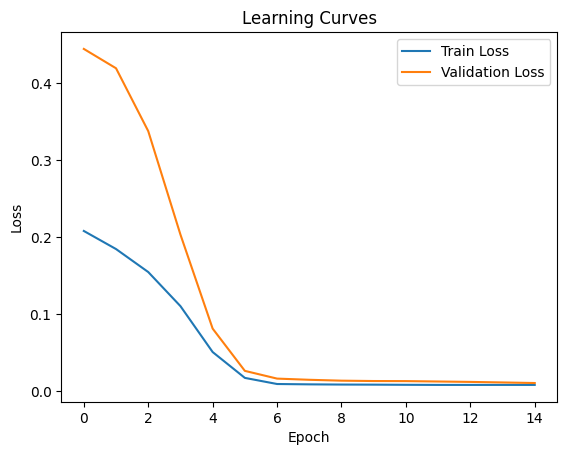

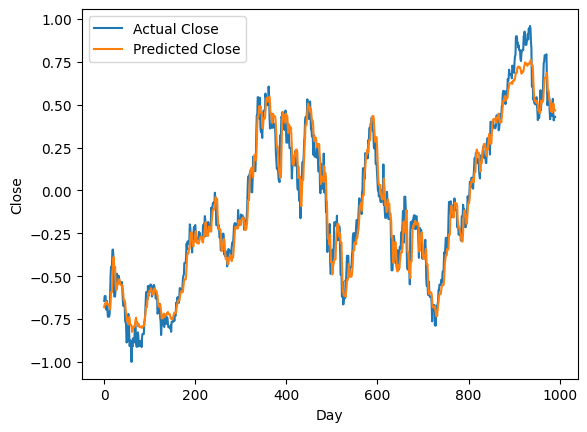

In [19]:
train_losses=[]
val_losses=[]

for epoch in range(num_epochs):
    train_loss= train_one_epoch()
    val_loss= validate_one_epoch()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

    with torch.no_grad():
        model.eval()
        predicted = model(X_train.to(device)).to('cpu').numpy()

# Plotting the learning curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves')
plt.show()
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [20]:
train_predictions = predicted.flatten()
dummies = np.zeros((X_train.shape[0], 3+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)
train_predictions = dc(dummies[:, 0])


array([129.38833468, 130.11722666, 130.11722666, 130.11722666,
       130.7542199 , 130.65804295, 130.09000056, 130.25387365,
       130.02055513, 130.02055513, 130.02055513, 130.02055513,
       129.34026814, 128.87636466, 130.1453201 , 132.98874798,
       132.98874798, 132.98874798, 135.89005111, 139.16206772,
       140.96934828, 141.44538472, 138.96421134, 138.96421134,
       138.96421134, 135.16216778, 133.60717143, 133.52207495,
       133.7474437 , 134.97843608, 134.97843608, 134.97843608,
       135.46385244, 136.03959122, 135.59027167, 135.12429731,
       134.67388629, 134.67388629, 134.67388629, 134.67388629,
       134.57605507, 133.75191682, 132.37166695, 131.01463296,
       131.01463296, 131.01463296, 130.41113696, 128.99562837,
       128.17528107, 127.42418673, 126.06092545, 126.06092545,
       126.06092545, 125.31060343, 126.6547906 , 127.08730427,
       126.58254338, 125.15902899, 125.15902899, 125.15902899,
       124.80432227, 123.5163244 , 124.07371267, 123.93

In [21]:
dummies = np.zeros((X_train.shape[0], 3+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([130.92000064, 132.04999943, 132.04999943, 132.04999943,
       128.97999925, 128.80000003, 130.88999955, 128.91000077,
       127.13999987, 127.13999987, 127.13999987, 127.13999987,
       127.83000055, 132.02999952, 136.8700006 , 139.06999965,
       139.06999965, 139.06999965, 142.92000013, 143.16000031,
       142.06000018, 137.08999965, 131.96000104, 131.96000104,
       131.96000104, 134.13999896, 134.98999895, 133.93999982,
       137.38999958, 136.75999986, 136.75999986, 136.75999986,
       136.91000043, 136.00999943, 135.38999967, 135.13000079,
       135.36999975, 135.36999975, 135.36999975, 135.36999975,
       133.18999939, 130.84000099, 129.70999976, 129.86999907,
       129.86999907, 129.86999907, 125.9999999 , 125.86000051,
       125.34999905, 120.99000077, 121.26000083, 121.26000083,
       121.26000083, 127.79000072, 125.11999882, 122.05999982,
       120.1299996 , 121.42000014, 121.42000014, 121.42000014,
       116.36      , 121.08500097, 119.97999903, 121.96

In [22]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], 3+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([175.52901185, 175.92869097, 174.88797916, 173.4103366 ,
       172.19289758, 172.19289758, 172.19289758, 172.14613447,
       173.3776129 , 173.68221264, 174.32855046, 174.87885507,
       174.87885507, 174.87885507, 176.42069031, 177.83675803,
       178.45671638, 179.05174366, 179.56759965, 179.56759965,
       179.56759965, 179.39900737, 179.08996984, 178.20864826,
       177.34889681, 176.59505184, 176.59505184, 176.59505184,
       175.28442526, 174.55572697, 174.23102377, 173.45807425,
       171.13197633, 171.13197633, 171.13197633, 169.86252754,
       170.1907415 , 171.34532174, 173.24950163, 175.62173042,
       175.62173042, 175.62173042, 176.85657344, 178.2004451 ,
       179.49999365, 180.82962369, 181.3077895 , 181.3077895 ,
       181.3077895 , 182.53831898, 182.76559538, 183.74853426,
       184.14677106, 185.00590976, 185.00590976, 185.00590976,
       185.33507633, 185.95018393, 186.01406476, 186.01406476,
       186.2456949 , 186.2456949 , 186.2456949 , 185.93

In [23]:
dummies = np.zeros((X_test.shape[0], 3+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([176.07999985, 171.96000054, 170.42999982, 170.68999992,
       171.21000012, 171.21000012, 171.21000012, 173.75000014,
       172.39999986, 173.66000053, 174.91000002, 177.48999987,
       177.48999987, 177.48999987, 178.9899995 , 178.38999965,
       179.79999967, 180.70999941, 178.85000011, 178.85000011,
       178.85000011, 178.71999945, 177.15000012, 175.83999967,
       175.46000009, 172.88000023, 172.88000023, 172.88000023,
       172.99999972, 173.44000026, 171.10000059, 166.88999984,
       168.21999959, 168.21999959, 168.21999959, 170.29000042,
       170.76999958, 173.97000041, 177.56999953, 176.64999984,
       176.64999984, 176.64999984, 179.23000091, 181.82000072,
       182.88999976, 182.40999939, 186.40000048, 186.40000048,
       186.40000048, 184.80000006, 187.44000088, 188.00999964,
       189.70999963, 189.68999972, 189.68999972, 189.68999972,
       191.44999944, 190.63999928, 191.31000005, 191.31000005,
       189.97000095, 189.97000095, 189.97000095, 189.78

In [24]:
print(test_predictions)

[175.52901185 175.92869097 174.88797916 173.4103366  172.19289758
 172.19289758 172.19289758 172.14613447 173.3776129  173.68221264
 174.32855046 174.87885507 174.87885507 174.87885507 176.42069031
 177.83675803 178.45671638 179.05174366 179.56759965 179.56759965
 179.56759965 179.39900737 179.08996984 178.20864826 177.34889681
 176.59505184 176.59505184 176.59505184 175.28442526 174.55572697
 174.23102377 173.45807425 171.13197633 171.13197633 171.13197633
 169.86252754 170.1907415  171.34532174 173.24950163 175.62173042
 175.62173042 175.62173042 176.85657344 178.2004451  179.49999365
 180.82962369 181.3077895  181.3077895  181.3077895  182.53831898
 182.76559538 183.74853426 184.14677106 185.00590976 185.00590976
 185.00590976 185.33507633 185.95018393 186.01406476 186.01406476
 186.2456949  186.2456949  186.2456949  185.93894997 185.77265515
 185.74433514 185.56611688 185.62073231 185.62073231 185.62073231
 185.90119644 185.72284662 186.53286384 186.64977648 187.34109766
 187.34109

In [38]:
len(new_y_test)

248

In [44]:
new_y_test

array([176.07999985, 171.96000054, 170.42999982, 170.68999992,
       171.21000012, 171.21000012, 171.21000012, 173.75000014,
       172.39999986, 173.66000053, 174.91000002, 177.48999987,
       177.48999987, 177.48999987, 178.9899995 , 178.38999965,
       179.79999967, 180.70999941, 178.85000011, 178.85000011,
       178.85000011, 178.71999945, 177.15000012, 175.83999967,
       175.46000009, 172.88000023, 172.88000023, 172.88000023,
       172.99999972, 173.44000026, 171.10000059, 166.88999984,
       168.21999959, 168.21999959, 168.21999959, 170.29000042,
       170.76999958, 173.97000041, 177.56999953, 176.64999984,
       176.64999984, 176.64999984, 179.23000091, 181.82000072,
       182.88999976, 182.40999939, 186.40000048, 186.40000048,
       186.40000048, 184.80000006, 187.44000088, 188.00999964,
       189.70999963, 189.68999972, 189.68999972, 189.68999972,
       191.44999944, 190.63999928, 191.31000005, 191.31000005,
       189.97000095, 189.97000095, 189.97000095, 189.78

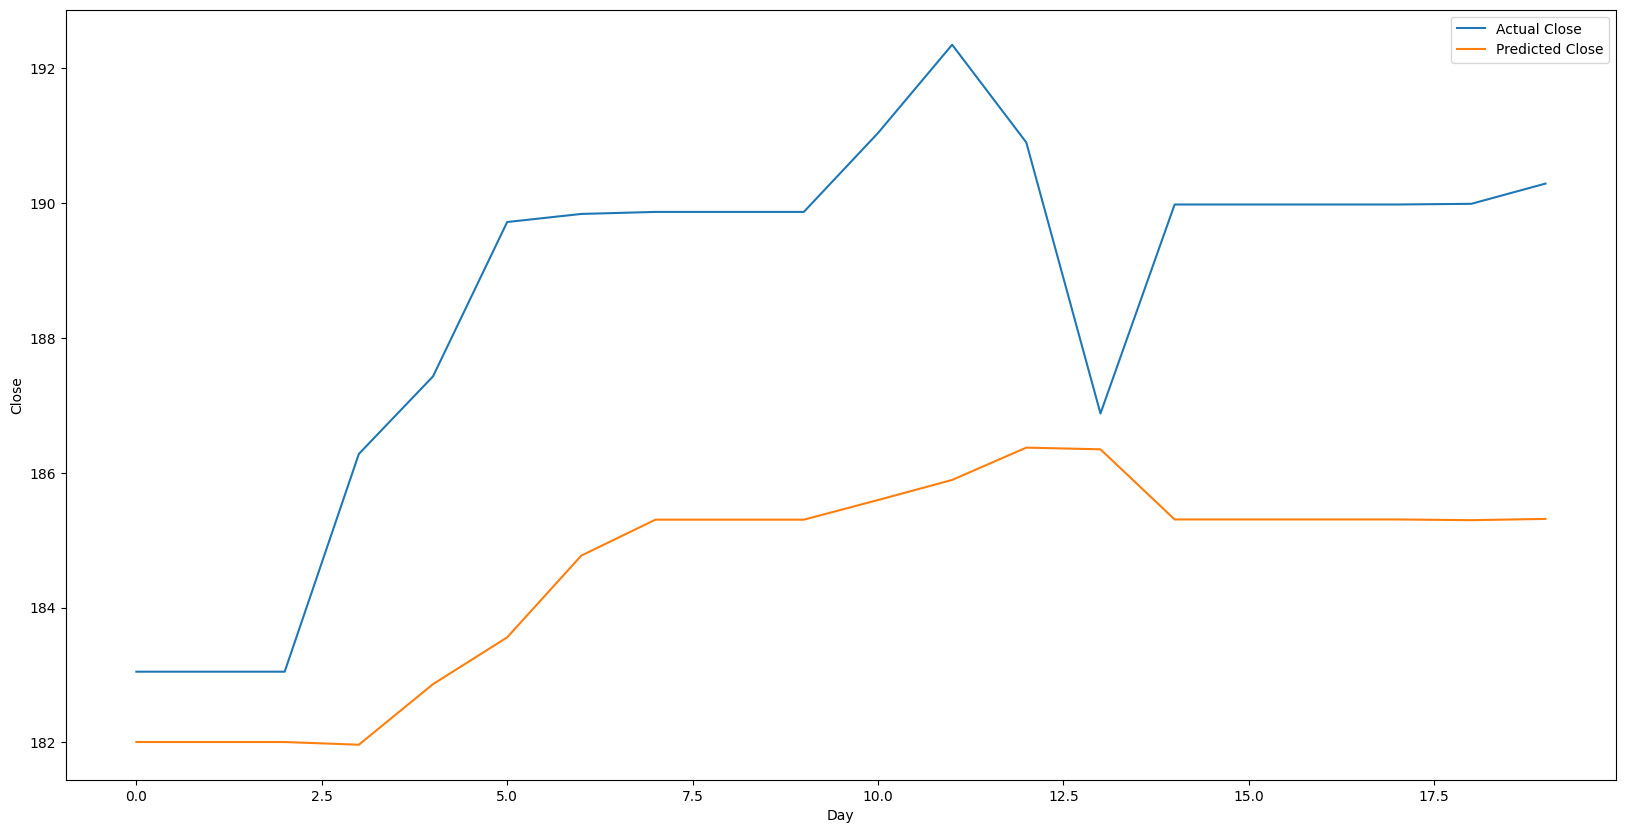

In [43]:
plt.figure(figsize=(20,10))
plt.plot(new_y_test[-20:], label='Actual Close')
plt.plot(test_predictions[-20:], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

Epoch 1/15, Train Loss: 0.009856598185641425, Validation Loss: 0.01064081518312118
Epoch 2/15, Train Loss: 0.008630295816276754, Validation Loss: 0.01064081518312118
Epoch 3/15, Train Loss: 0.00785301239063431, Validation Loss: 0.01064081518312118
Epoch 4/15, Train Loss: 0.007276564196217805, Validation Loss: 0.01064081518312118
Epoch 5/15, Train Loss: 0.006779482596487339, Validation Loss: 0.01064081518312118
Epoch 6/15, Train Loss: 0.006385887083264866, Validation Loss: 0.01064081518312118
Epoch 7/15, Train Loss: 0.006085634996582355, Validation Loss: 0.01064081518312118
Epoch 8/15, Train Loss: 0.00585504383447447, Validation Loss: 0.01064081518312118
Epoch 9/15, Train Loss: 0.005678578496112355, Validation Loss: 0.01064081518312118
Epoch 10/15, Train Loss: 0.005545039736067078, Validation Loss: 0.01064081518312118
Epoch 11/15, Train Loss: 0.005444264671366129, Validation Loss: 0.01064081518312118
Epoch 12/15, Train Loss: 0.005368142546753266, Validation Loss: 0.01064081518312118
Epo

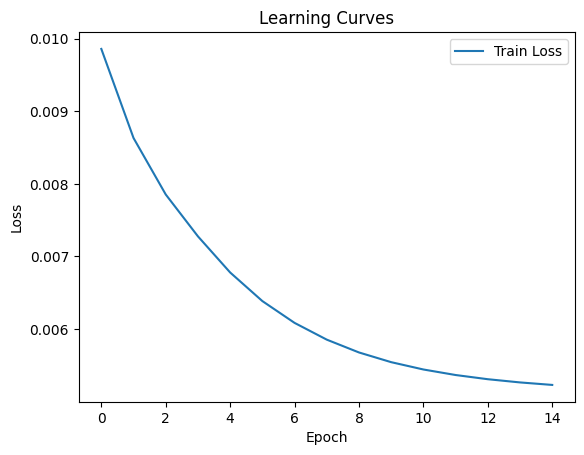

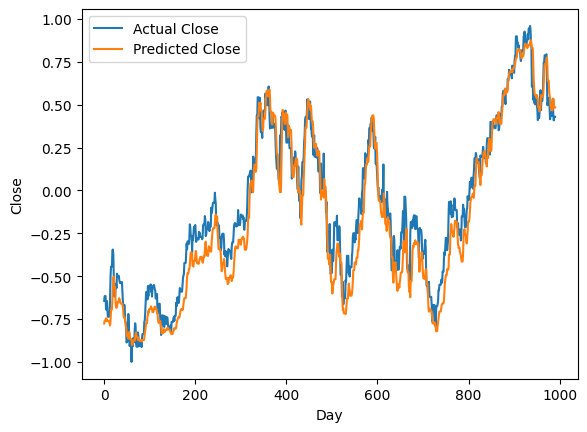

In [46]:
train_loader= test_loader

def train_one_epoch():
    model.train(True)
    # print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for _, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_train_loss = running_loss / len(train_loader)
    return avg_train_loss

train_losses=[]

for epoch in range(num_epochs):
    train_loss= train_one_epoch()
    
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}')

    with torch.no_grad():
        model.eval()
        predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train[-50:], label='Actual Close')
plt.plot(predicted[-50:], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

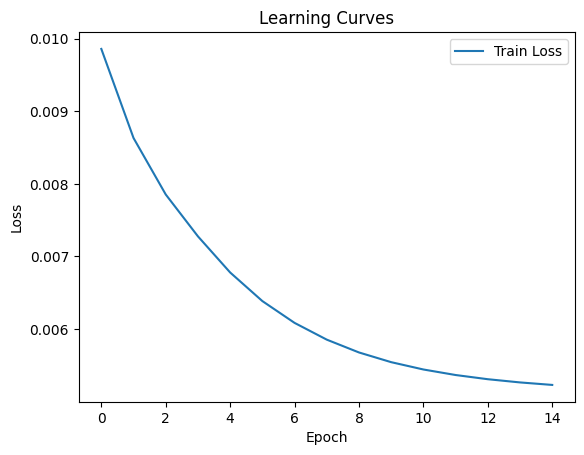

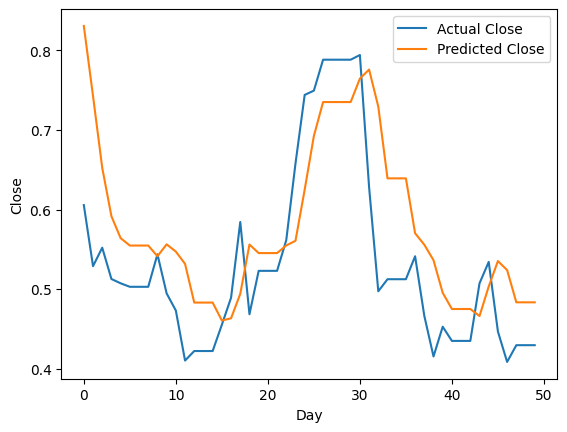

In [47]:
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curves')
plt.show()
plt.plot(y_train[-50:], label='Actual Close')
plt.plot(predicted[-50:], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()